In [1]:
import requests
import json
import os
from pprint import pprint
from pymongo import MongoClient
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

NYC Rat Data Source: https://data.cityofnewyork.us/Health/Rodent-Inspection/p937-wjvj

Notes for the NYC Rat Data API:

Base URL:
The base URL for the API is "https://data.cityofnewyork.us/resource/p937-wjvj.json".

Parameters:

--"inspection_type" (text): Specify the type of inspection (e.g., "Initial", "Compliance", etc.).
Lets look at initial and compliance for this category, per the data: "Initial Inspection - Inspection conducted in response to a 311 complaint, or a proactive inspection conducted through our neighborhood indexing program" and
"Compliance Inspection - If a property fails its initial inspection, the Health Department will conduct a follow up
(Compliance) inspection"


--"job_ticket_or_work_order_id" (number): Use this parameter if you want to filter by a specific job ticket or work order ID.
keep for now for reference purposes. i do not think we need this to train the nn, but more is better to start


--"borough" (text): Specify the borough you want to filter by (e.g., "Manhattan", "Brooklyn", etc.).
keep this too. this is our location data


--"result" (text): Specify the result of the inspection (e.g., "Active Rat Signs", "Problem Conditions", etc.).
Active Rat Signs (ARS) - ARS include any of six different signs: 1) fresh tracks, 2) fresh droppings, 3) active burrows,
4) active runways and rub marks, 5) fresh gnawing marks, and 6) live rats. 
Problem Conditions - Problem conditions include garbage (poor containerization of food waste resulting in the feeding
of rats), harborage (clutter and dense vegetation promoting the nesting of rats), and mice.

this field needs to be analyzed, not sure what data is going to come back and how we will parse. TBD.

--"inspection_date" (Floating Timestamp): date of inspection

This site: https://dev.socrata.com/foundry/data.cityofnewyork.us/p937-wjvj hosts a CSV file of the above data if we dont want to screw with the api

Notes on data limitations: Please note that if a property/taxlot does not appear in the file, that does not indicate an absence of rats - rather just that it has not been inspected. Similarly, neighborhoods with higher numbers properties with active rat signs may not actually have higher rat populations but simply have more inspections.

Find out which Boro has the most rats (measure initial and compliance). Drill down to that Boro. Analyze data for Problem Conditions which turn into Active Rat Signs and for how long. See if you can train an API on potential active rat situations.

In [2]:
client = MongoClient('localhost', 27017)

# Select your database
db = client['nyc']

# Select your collection
collection = db['rats']

(source:https://rattrapinc.com/new-york-city-rat-facts/) Rat lifespan: rats live about 1 year and begin reproducing at 2-3 months old. New York City rats like to burrow, nest, and hide in soft dirt at ground level or below, and live in colonies, or families of 30 to 50 rats with 9 to a burrow. These rats will live between 100 and 400 feet from their food source, and in their lifetime will rarely travel more than 600 feet from where they are born.

With this information, we should focus on a time span of not more than 5 years, but not less than 1-2 years. I also think we should focus on one Borough. Research shows Brooklyn to be the most rat-infested Borough (https://www.stat.cmu.edu/capstoneresearch/fall2022/315files_f22/team6.html) (plus our dataset shows the same). 

Using the data at hand, I beleive we should look at inspection results, by street name, over a period of 2-5 years to see if there is a trend in rat growth, if treatment is working, etc.

Other potential variables: weather, longer/shorter time spans, etc.

Cleaning steps:
1. Remove empty data
2. Drill down by Borough (maybe use df's grouped by borough for visualization)
3. Remove data out of date threshold (easier to clean if sorted by borough)
4. Manipulate
5. ???
6. Profit

Addtional info: There is a rat sightings nyc db as well (https://data.cityofnewyork.us/Social-Services/Rat-Sightings/3q43-55fe). This could be used for cross referencing, etc. I decided to stick with the initial dataset, because rat sightings could be subjective (and they are investigated by various agencies per that dataset's information) 

Mongo DB Cleaning:
Import CSV > remove JOB_TICKET_OR_WORK_ORDER_ID, JOB_ID, JOB_PROGRESS, BBL, BORO_CODE, BLOCK, LOT, HOUSE_NUMBER, STREET_NAME, X_COORD, Y_COORD, LATITUDE, LONGITUDE, APPROVED_DATE, LOCATION, COMMUNITY BOARD, COUNCIL DISTRICT, CENSUS TRACT, BIN, NTA > Change INSPECTION_DATE to Date format

In [3]:
#Clean out empty data
# Define the fields that should be present and non-empty in every document
fields_to_check = [
    "INSPECTION_TYPE",
    "ZIP_CODE",
    "BOROUGH",
    "INSPECTION_DATE",
    "RESULT"
]

# Construct the query to match documents where any of the specified fields is missing or has an empty/whitespace value
query = {"$or": []}
for field in fields_to_check:
    query["$or"].extend([
        {field: {"$exists": False}},
        {field: ""},
        {field: {"$regex": "^\s*$"}}
    ])
query["$or"].append({"ZIP_CODE": 0})

# Delete documents matching the query
result = collection.delete_many(query)

# Print the result of the delete operation
print(f"Deleted {result.deleted_count} documents.")

Deleted 0 documents.


In [4]:
#Remove all documents with an Inspection Date before 2023
# Define the date threshold
threshold_date = datetime(2023, 1, 1)

# Remove documents with an INSPECTION_DATE before 2023
result = collection.delete_many({
    "INSPECTION_DATE": {
        "$lt": threshold_date
    }
})

print(f"{result.deleted_count} documents were deleted.")


0 documents were deleted.


In [5]:
cursor = collection.find({})
df = pd.DataFrame(list(cursor))

In [6]:
df.drop(columns=['_id'], inplace=True) 

In [7]:
#RAT ACTIVITY IS THE TARGET OF OUR ML MODEL
# Create a new column "Rat Activity" and initialize with 0
df['RAT_ACTIVITY'] = 0

# Set the "Rat_Activity" column to 1 where there is rat activity
df.loc[(df['INSPECTION_TYPE'] == 'Initial') & (df['RESULT'] == 'Rat Activity'), 'RAT_ACTIVITY'] = 1
df.loc[(df['INSPECTION_TYPE'] == 'Compliance') & (df['RESULT'] == 'Rat Activity'), 'RAT_ACTIVITY'] = 1
df.loc[df['INSPECTION_TYPE'].isin(['BAIT', 'STOPPAGE', 'CLEAN_UPS']), 'RAT_ACTIVITY'] = 1

df


,INSPECTION_TYPE,ZIP_CODE,BOROUGH,INSPECTION_DATE,RESULT,RAT_ACTIVITY
0,Initial,10469,Bronx,2023-03-10 20:10:27,Passed,0
1,Initial,10029,Manhattan,2023-03-24 12:30:00,Rat Activity,1
2,Initial,10027,Manhattan,2023-01-20 19:31:22,Passed,0
3,Initial,11221,Brooklyn,2023-05-12 18:22:44,Passed,0
4,Initial,10451,Bronx,2023-01-19 21:08:39,Passed,0
...,...,...,...,...,...,...
165367,Initial,10065,Manhattan,2023-02-03 16:55:09,Passed,0
165368,Initial,10458,Bronx,2023-02-03 20:30:05,Passed,0
165369,Compliance,11211,Brooklyn,2023-05-26 17:10:32,Rat Activity,1
165370,Initial,11206,Brooklyn,2023-02-03 21:00:12,Rat Activity,1


In [8]:
#Data engineering features
# Convert the 'INSPECTION_DATE' column to datetime format
df['INSPECTION_DATE'] = pd.to_datetime(df['INSPECTION_DATE'])

# Extract the month from the 'INSPECTION_DATE' column
df['INSPECTION_MONTH'] = df['INSPECTION_DATE'].dt.month

# Print the updated dataframe
print(df[['INSPECTION_DATE', 'INSPECTION_MONTH']])

           INSPECTION_DATE  INSPECTION_MONTH
0      2023-03-10 20:10:27                 3
1      2023-03-24 12:30:00                 3
2      2023-01-20 19:31:22                 1
3      2023-05-12 18:22:44                 5
4      2023-01-19 21:08:39                 1
...                    ...               ...
165367 2023-02-03 16:55:09                 2
165368 2023-02-03 20:30:05                 2
165369 2023-05-26 17:10:32                 5
165370 2023-02-03 21:00:12                 2
165371 2023-03-02 18:51:42                 3

[165372 rows x 2 columns]


The encoding method you've used for ZIP codes is known as target (or mean) encoding. This method involves encoding a categorical variable based on the mean of the target variable for each category. It can be a powerful way of encoding categorical variables when the number of categories is large, and there's a relationship between the categories and the target.

In [9]:
# Group the data by ZIP code and compute the mean of RAT_ACTIVITY
mean_rat_activity = df.groupby('ZIP_CODE')['RAT_ACTIVITY'].mean()

# Create a dictionary mapping each ZIP code to its corresponding mean
zip_code_to_mean = dict(mean_rat_activity)

# Replace the values in the ZIP_CODE column with the values from the dictionary
df['ZIP_CODE_ENCODED'] = df['ZIP_CODE'].map(zip_code_to_mean)


In [10]:
df_ml = df.drop(columns=['ZIP_CODE', 'INSPECTION_DATE', 'RESULT'])

In [11]:
# One-hot encode the INSPECTION_TYPE and BOROUGH columns
df_ml = pd.get_dummies(df_ml, columns=['INSPECTION_TYPE', 'BOROUGH'], drop_first=True)

# Display the resulting dataframe
df_ml.head()

,RAT_ACTIVITY,INSPECTION_MONTH,ZIP_CODE_ENCODED,INSPECTION_TYPE_CLEAN_UPS,INSPECTION_TYPE_Compliance,INSPECTION_TYPE_Initial,INSPECTION_TYPE_STOPPAGE,BOROUGH_Brooklyn,BOROUGH_Manhattan,BOROUGH_Queens,BOROUGH_Staten Island
0,0,3,0.021053,0,0,1,0,0,0,0,0
1,1,3,0.637914,0,0,1,0,0,1,0,0
2,0,1,0.470306,0,0,1,0,0,1,0,0
3,0,5,0.383615,0,0,1,0,1,0,0,0
4,0,1,0.503724,0,0,1,0,0,0,0,0


In [12]:
# Split our preprocessed data into our features and target arrays
y = df_ml["RAT_ACTIVITY"].values
X = df_ml.drop(columns=["RAT_ACTIVITY"]).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [13]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [14]:
print(X_train_scaled.shape)

(124029, 10)


In [15]:
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=16, activation="relu", input_dim=X_train_scaled.shape[1]))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=8, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                176       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Compile the model
nn.compile(optimizer='adam',
           loss='binary_crossentropy',
           metrics=['accuracy'])

# Train the model
history = nn.fit(
    X_train_scaled,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_scaled, y_test)
)


Epoch 1/50
3876/3876 [==============================] - 5s 1ms/step - loss: 0.4295 - accuracy: 0.7945 - val_loss: 0.4162 - val_accuracy: 0.7996
Epoch 2/50
3876/3876 [==============================] - 4s 1ms/step - loss: 0.4162 - accuracy: 0.7991 - val_loss: 0.4168 - val_accuracy: 0.7956
Epoch 3/50
3876/3876 [==============================] - 4s 1ms/step - loss: 0.4155 - accuracy: 0.7992 - val_loss: 0.4154 - val_accuracy: 0.7999
Epoch 4/50
3876/3876 [==============================] - 4s 1ms/step - loss: 0.4151 - accuracy: 0.7998 - val_loss: 0.4179 - val_accuracy: 0.7995
Epoch 5/50
3876/3876 [==============================] - 4s 1ms/step - loss: 0.4150 - accuracy: 0.7997 - val_loss: 0.4148 - val_accuracy: 0.7998
Epoch 6/50
3876/3876 [==============================] - 4s 1ms/step - loss: 0.4147 - accuracy: 0.8000 - val_loss: 0.4147 - val_accuracy: 0.7979
Epoch 7/50
3876/3876 [==============================] - 5s 1ms/step - loss: 0.4144 - accuracy: 0.8003 - val_loss: 0.4158 - val_accuracy:

In [17]:
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

1292/1292 - 1s - loss: 0.4129 - accuracy: 0.8007 - 917ms/epoch - 710us/step
Loss: 0.4128721058368683, Accuracy: 0.8006917834281921


That was the test of the nn on the full data set. Now we will train it on the boroughs to see how it does there. We will look at Brooklyn, Bronx and Manhattan (highest incidences of rats)

In [18]:
# Filter the DataFrame into separate DataFrames for each borough
staten_island = df[df['BOROUGH'] == 'Staten Island']
bronx = df[df['BOROUGH'] == 'Bronx']
brooklyn = df[df['BOROUGH'] == 'Brooklyn']
manhattan = df[df['BOROUGH'] == 'Manhattan']
queens = df[df['BOROUGH'] == 'Queens']


In [19]:
def preprocess_borough_data(borough_data):
    # Drop the unnecessary columns
    borough_data.drop(columns=['INSPECTION_DATE', 'RESULT', 'BOROUGH'], inplace=True)

    # One-hot encode the INSPECTION_TYPE column
    borough_data = pd.get_dummies(borough_data, columns=['INSPECTION_TYPE'], drop_first=True)

    # Drop the ZIP_CODE column (since we already have the encoded version)
    borough_data.drop(columns=['ZIP_CODE'], inplace=True)
    
    return borough_data

# Preprocess the data for each borough
staten_island_ml = preprocess_borough_data(staten_island)
bronx_ml = preprocess_borough_data(bronx)
brooklyn_ml = preprocess_borough_data(brooklyn)
manhattan_ml = preprocess_borough_data(manhattan)
queens_ml = preprocess_borough_data(queens)

C:\Users\abrid\anaconda3\envs\PythonData\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


BROOKLYN DATA TEST

In [20]:
# Split our preprocessed data into our features and target arrays
y = brooklyn_ml["RAT_ACTIVITY"].values
X = brooklyn_ml.drop(columns=["RAT_ACTIVITY"]).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [21]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

print(X_train_scaled.shape)

(36886, 6)


In [22]:
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=16, activation="relu", input_dim=X_train_scaled.shape[1]))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=8, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                112       
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Compile the model
nn.compile(optimizer='adam',
           loss='binary_crossentropy',
           metrics=['accuracy'])

# Train the model
history = nn.fit(
    X_train_scaled,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_scaled, y_test)
)

Epoch 1/50
1153/1153 [==============================] - 2s 1ms/step - loss: 0.4751 - accuracy: 0.7751 - val_loss: 0.4431 - val_accuracy: 0.7890
Epoch 2/50
1153/1153 [==============================] - 1s 1ms/step - loss: 0.4480 - accuracy: 0.7864 - val_loss: 0.4427 - val_accuracy: 0.7898
Epoch 3/50
1153/1153 [==============================] - 1s 1ms/step - loss: 0.4470 - accuracy: 0.7872 - val_loss: 0.4412 - val_accuracy: 0.7907
Epoch 4/50
1153/1153 [==============================] - 1s 1ms/step - loss: 0.4466 - accuracy: 0.7878 - val_loss: 0.4412 - val_accuracy: 0.7901
Epoch 5/50
1153/1153 [==============================] - 1s 1ms/step - loss: 0.4464 - accuracy: 0.7878 - val_loss: 0.4415 - val_accuracy: 0.7911
Epoch 6/50
1153/1153 [==============================] - 1s 1ms/step - loss: 0.4463 - accuracy: 0.7872 - val_loss: 0.4408 - val_accuracy: 0.7909
Epoch 7/50
1153/1153 [==============================] - 1s 1ms/step - loss: 0.4461 - accuracy: 0.7885 - val_loss: 0.4412 - val_accuracy:

In [24]:
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

385/385 - 0s - loss: 0.4389 - accuracy: 0.7905 - 284ms/epoch - 737us/step
Loss: 0.4389302134513855, Accuracy: 0.7905009984970093


BRONX DATA TEST

In [25]:
# Split our preprocessed data into our features and target arrays
y = bronx_ml["RAT_ACTIVITY"].values
X = bronx_ml.drop(columns=["RAT_ACTIVITY"]).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [26]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

print(X_train_scaled.shape)

(35812, 6)


In [27]:
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=16, activation="relu", input_dim=X_train_scaled.shape[1]))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=8, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                112       
                                                                 
 dense_7 (Dense)             (None, 8)                 136       
                                                                 
 dense_8 (Dense)             (None, 1)                 9         
                                                                 
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Compile the model
nn.compile(optimizer='adam',
           loss='binary_crossentropy',
           metrics=['accuracy'])

# Train the model
history = nn.fit(
    X_train_scaled,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_scaled, y_test)
)

Epoch 1/50
1120/1120 [==============================] - 2s 1ms/step - loss: 0.4425 - accuracy: 0.7909 - val_loss: 0.4238 - val_accuracy: 0.7950
Epoch 2/50
1120/1120 [==============================] - 1s 1ms/step - loss: 0.4217 - accuracy: 0.7959 - val_loss: 0.4229 - val_accuracy: 0.7943
Epoch 3/50
1120/1120 [==============================] - 1s 1ms/step - loss: 0.4209 - accuracy: 0.7956 - val_loss: 0.4220 - val_accuracy: 0.7949
Epoch 4/50
1120/1120 [==============================] - 1s 1ms/step - loss: 0.4205 - accuracy: 0.7957 - val_loss: 0.4224 - val_accuracy: 0.7916
Epoch 5/50
1120/1120 [==============================] - 1s 1ms/step - loss: 0.4204 - accuracy: 0.7961 - val_loss: 0.4221 - val_accuracy: 0.7952
Epoch 6/50
1120/1120 [==============================] - 1s 1ms/step - loss: 0.4201 - accuracy: 0.7950 - val_loss: 0.4221 - val_accuracy: 0.7940
Epoch 7/50
1120/1120 [==============================] - 1s 1ms/step - loss: 0.4198 - accuracy: 0.7959 - val_loss: 0.4215 - val_accuracy:

In [29]:
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

374/374 - 0s - loss: 0.4206 - accuracy: 0.7934 - 262ms/epoch - 701us/step
Loss: 0.4206172525882721, Accuracy: 0.7934327125549316


MANHATTAN DATA TEST

In [30]:
# Split our preprocessed data into our features and target arrays
y = manhattan_ml["RAT_ACTIVITY"].values
X = manhattan_ml.drop(columns=["RAT_ACTIVITY"]).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [31]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

print(X_train_scaled.shape)

(41154, 6)


In [32]:
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=16, activation="relu", input_dim=X_train_scaled.shape[1]))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=8, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 16)                112       
                                                                 
 dense_10 (Dense)            (None, 8)                 136       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Compile the model
nn.compile(optimizer='adam',
           loss='binary_crossentropy',
           metrics=['accuracy'])

# Train the model
history = nn.fit(
    X_train_scaled,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_scaled, y_test)
)

Epoch 1/50
1287/1287 [==============================] - 2s 1ms/step - loss: 0.4316 - accuracy: 0.7954 - val_loss: 0.3924 - val_accuracy: 0.8108
Epoch 2/50
1287/1287 [==============================] - 2s 1ms/step - loss: 0.3895 - accuracy: 0.8177 - val_loss: 0.3913 - val_accuracy: 0.8131
Epoch 3/50
1287/1287 [==============================] - 1s 1ms/step - loss: 0.3883 - accuracy: 0.8177 - val_loss: 0.3912 - val_accuracy: 0.8118
Epoch 4/50
1287/1287 [==============================] - 2s 1ms/step - loss: 0.3874 - accuracy: 0.8184 - val_loss: 0.3909 - val_accuracy: 0.8122
Epoch 5/50
1287/1287 [==============================] - 1s 1ms/step - loss: 0.3871 - accuracy: 0.8178 - val_loss: 0.3890 - val_accuracy: 0.8143
Epoch 6/50
1287/1287 [==============================] - 2s 1ms/step - loss: 0.3867 - accuracy: 0.8174 - val_loss: 0.3884 - val_accuracy: 0.8141
Epoch 7/50
1287/1287 [==============================] - 1s 1ms/step - loss: 0.3866 - accuracy: 0.8179 - val_loss: 0.3887 - val_accuracy:

In [34]:
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

429/429 - 0s - loss: 0.3878 - accuracy: 0.8135 - 347ms/epoch - 808us/step
Loss: 0.3878409266471863, Accuracy: 0.8135432600975037


QUEENS DATASET (testing this data set because it is similar to Manhattan in its data split, curious to see the results)

In [43]:
# Split our preprocessed data into our features and target arrays
y = queens_ml["RAT_ACTIVITY"].values
X = queens_ml.drop(columns=["RAT_ACTIVITY"]).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [44]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

print(X_train_scaled.shape)

(8466, 5)


In [45]:
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=16, activation="relu", input_dim=X_train_scaled.shape[1]))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=8, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 16)                96        
                                                                 
 dense_13 (Dense)            (None, 8)                 136       
                                                                 
 dense_14 (Dense)            (None, 1)                 9         
                                                                 
Total params: 241
Trainable params: 241
Non-trainable params: 0
_________________________________________________________________


In [46]:
# Compile the model
nn.compile(optimizer='adam',
           loss='binary_crossentropy',
           metrics=['accuracy'])

# Train the model
history = nn.fit(
    X_train_scaled,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_scaled, y_test)
)

Epoch 1/50
265/265 [==============================] - 1s 2ms/step - loss: 0.5740 - accuracy: 0.7004 - val_loss: 0.4704 - val_accuracy: 0.7707
Epoch 2/50
265/265 [==============================] - 0s 1ms/step - loss: 0.4520 - accuracy: 0.7609 - val_loss: 0.4251 - val_accuracy: 0.7792
Epoch 3/50
265/265 [==============================] - 0s 1ms/step - loss: 0.4314 - accuracy: 0.7639 - val_loss: 0.4192 - val_accuracy: 0.7668
Epoch 4/50
265/265 [==============================] - 0s 1ms/step - loss: 0.4262 - accuracy: 0.7600 - val_loss: 0.4137 - val_accuracy: 0.7679
Epoch 5/50
265/265 [==============================] - 0s 1ms/step - loss: 0.4243 - accuracy: 0.7580 - val_loss: 0.4129 - val_accuracy: 0.7651
Epoch 6/50
265/265 [==============================] - 0s 1ms/step - loss: 0.4227 - accuracy: 0.7602 - val_loss: 0.4088 - val_accuracy: 0.7739
Epoch 7/50
265/265 [==============================] - 0s 1ms/step - loss: 0.4220 - accuracy: 0.7629 - val_loss: 0.4091 - val_accuracy: 0.7807
Epoch 

In [47]:
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

89/89 - 0s - loss: 0.4042 - accuracy: 0.7810 - 76ms/epoch - 858us/step
Loss: 0.4041619598865509, Accuracy: 0.781006395816803


Testing Notes:

Base test: 16/8/1/50 epochs
Full Dataset: 1292/1292 - 1s - loss: 0.4138 - accuracy: 0.8003 - 858ms/epoch - 664us/step
Loss: 0.4137950539588928, Accuracy: 0.8003047704696655

Brooklyn: 385/385 - 0s - loss: 0.4390 - accuracy: 0.7908 - 273ms/epoch - 708us/step
Loss: 0.4390130043029785, Accuracy: 0.7908262610435486

Bronx: 374/374 - 0s - loss: 0.4202 - accuracy: 0.7940 - 264ms/epoch - 707us/step
Loss: 0.4202301502227783, Accuracy: 0.7940191030502319

Manhattan: 429/429 - 0s - loss: 0.3873 - accuracy: 0.8155 - 338ms/epoch - 788us/step
Loss: 0.38726359605789185, Accuracy: 0.8155113458633423

Queens: 89/89 - 0s - loss: 0.4042 - accuracy: 0.7810 - 76ms/epoch - 858us/step
Loss: 0.4041619598865509, Accuracy: 0.781006395816803

First Test: 32/16/1/100 epochs


Per the NYC open data:

"Initial Inspection - Inspection conducted in response to a 311 complaint, or a proactive inspection conducted through our neighborhood indexing program" and "Compliance Inspection - If a property fails its initial inspection, the Health Department will conduct a follow up (Compliance) inspection"

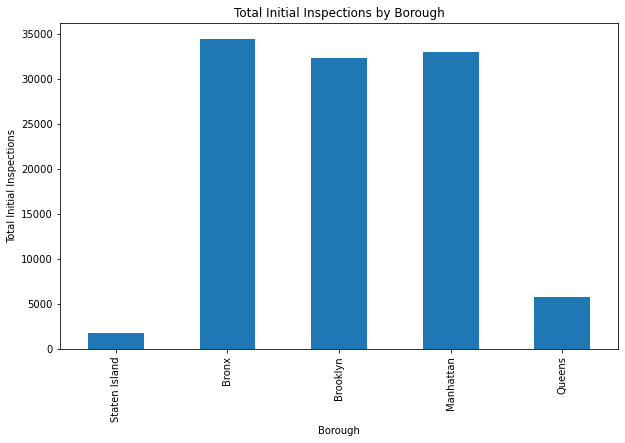

In [35]:
# Create a dictionary to store the total initial inspections for each borough
borough_totals = {
    'Staten Island': len(staten_island[staten_island['INSPECTION_TYPE'] == 'Initial']),
    'Bronx': len(bronx[bronx['INSPECTION_TYPE'] == 'Initial']),
    'Brooklyn': len(brooklyn[brooklyn['INSPECTION_TYPE'] == 'Initial']),
    'Manhattan': len(manhattan[manhattan['INSPECTION_TYPE'] == 'Initial']),
    'Queens': len(queens[queens['INSPECTION_TYPE'] == 'Initial'])
}

# Convert the dictionary to a Pandas Series for easy plotting
borough_series = pd.Series(borough_totals)

# Create a bar chart
borough_series.plot(kind='bar', stacked=True, figsize=(10, 6))

# Customize the plot
plt.title('Total Initial Inspections by Borough')
plt.xlabel('Borough')
plt.ylabel('Total Initial Inspections')

# Show the plot
plt.savefig("./Graphics/total-initial-inspections-by-borough.png")
plt.show()

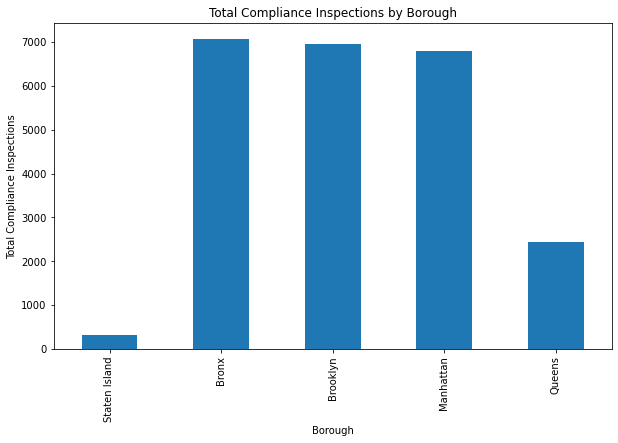

In [36]:
# Create a dictionary to store the total compliance inspections for each borough
borough_compliance = {
    'Staten Island': len(staten_island[staten_island['INSPECTION_TYPE'] == 'Compliance']),
    'Bronx': len(bronx[bronx['INSPECTION_TYPE'] == 'Compliance']),
    'Brooklyn': len(brooklyn[brooklyn['INSPECTION_TYPE'] == 'Compliance']),
    'Manhattan': len(manhattan[manhattan['INSPECTION_TYPE'] == 'Compliance']),
    'Queens': len(queens[queens['INSPECTION_TYPE'] == 'Compliance'])
}

# Convert the dictionary to a Pandas Series for easy plotting
borough_comp_series = pd.Series(borough_compliance)

# Create a bar chart
borough_comp_series.plot(kind='bar', stacked=True, figsize=(10, 6))

# Customize the plot
plt.title('Total Compliance Inspections by Borough')
plt.xlabel('Borough')
plt.ylabel('Total Compliance Inspections')

# Show the plot
plt.savefig("./Graphics/total-compliance-inspections-by-borough.png")
plt.show()

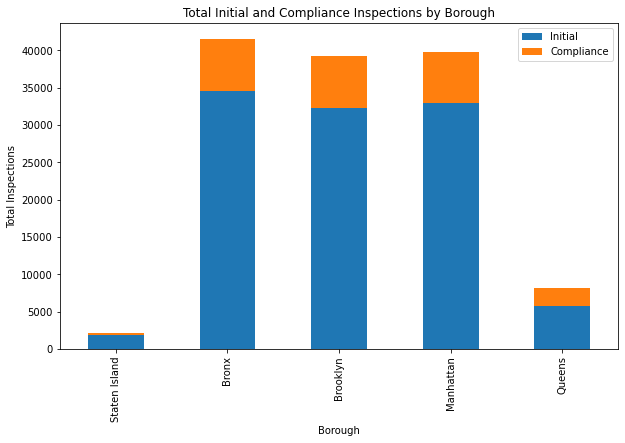

In [37]:
# Create a DataFrame to store the total initial and compliance inspections for each borough
borough_data = pd.DataFrame({
    'Borough': ['Staten Island', 'Bronx', 'Brooklyn', 'Manhattan', 'Queens'],
    'Initial': [
        len(staten_island[staten_island['INSPECTION_TYPE'] == 'Initial']),
        len(bronx[bronx['INSPECTION_TYPE'] == 'Initial']),
        len(brooklyn[brooklyn['INSPECTION_TYPE'] == 'Initial']),
        len(manhattan[manhattan['INSPECTION_TYPE'] == 'Initial']),
        len(queens[queens['INSPECTION_TYPE'] == 'Initial'])
    ],
    'Compliance': [
        len(staten_island[staten_island['INSPECTION_TYPE'] == 'Compliance']),
        len(bronx[bronx['INSPECTION_TYPE'] == 'Compliance']),
        len(brooklyn[brooklyn['INSPECTION_TYPE'] == 'Compliance']),
        len(manhattan[manhattan['INSPECTION_TYPE'] == 'Compliance']),
        len(queens[queens['INSPECTION_TYPE'] == 'Compliance'])
    ]
})

# Create a stacked bar chart
borough_data.set_index('Borough').plot(kind='bar', stacked=True, figsize=(10, 6))

# Customize the plot
plt.title('Total Initial and Compliance Inspections by Borough')
plt.xlabel('Borough')
plt.ylabel('Total Inspections')

# Save the plot
plt.savefig("./Graphics/total-inspections-by-Borough.png")

# Show the plot
plt.show()

In [38]:
# Display all unique values in the 'result' column for Brooklyn
unique_results = df['RESULT'].unique()

print("Unique Result Values:")
for result in unique_results:
    print(result)

Unique Result Values:
Passed
Rat Activity
Bait applied
Failed for Other R
Monitoring visit
Stoppage done
Cleanup done


In [39]:
# Display all unique values in the 'result' column for Brooklyn
unique_inspections = df['INSPECTION_TYPE'].unique()

print("Unique inspection type Values:")
for result in unique_inspections:
    print(result)

Unique inspection type Values:
Initial
Compliance
BAIT
STOPPAGE
CLEAN_UPS


Compliance visits are only triggered after the initial visit (if rat evidence is indicated). Similarly, for results: I think everything except Passed, failed for other R, and possibly clean up are indicative of rat activity. According to NYC Open data, here are the inspection categories:
Baiting - Application of rodenticide, or monitoring visit by a
Health Department Pest Control Professional.
Clean Up - The removal of garbage and clutter from a
property by the Health Department.
Stoppage – Sealing of holes and cracks allowing free
movement of pests.
Initial Inspection - Inspection conducted in response to a 311
complaint, or a proactive inspection conducted through our
neighborhood indexing program.
Compliance Inspection - If a property fails its initial
inspection, the Health Department will conduct a follow up
(Compliance) inspection.
Baiting - Application of rodenticide, or monitoring visit by a
Health Department Pest Control Professional.
Clean Up - The removal of garbage and clutter from a
property by the Health Department.

Filter Relevant Data: If we're interested in tracking the progression of rat activity and control measures, we should filter our data to only include records where an initial inspection resulted in a finding of rat activity.

In [ ]:
brooklyn_df

In [ ]:
job_id_counts = brooklyn_df['JOB_ID'].value_counts()

# Filter to only show job_ids that appear more than once
repeated_job_ids = job_id_counts[job_id_counts > 40]

print("Job_IDs that repeat and their frequencies:")
print(repeated_job_ids)


In [ ]:
# List of job IDs to filter
job_ids = ['PC7775029', 'PC7860266', 'PC7870102', 'PC7845837', 'PC7870111', 'PC7868958', 'PC7881156', 'PC7931761', 'PC7930725', 'PC7931755' ]

# Create an empty dictionary to store the filtered dataframes
filtered_dfs = {}

# Loop through the job IDs and create filtered dataframes for each
for job_id in job_ids:
    job_id_filter = brooklyn_df['JOB_ID'] == job_id
    filtered_df = brooklyn_df[job_id_filter]
    
    # Sort the filtered dataframe by the INSPECTION_DATE column
    sorted_filtered_df = filtered_df.sort_values(by='INSPECTION_DATE', ascending=True)
    
    filtered_dfs[job_id] = sorted_filtered_df

# Access the dataframe for a specific job ID
print("Dataframe for job ID PC7775029:")
filtered_dfs['PC7775029']

In [ ]:
# Create an empty dictionary to store the count of "passed" results for each job ID
passed_counts = {}

# Loop through the filtered dataframes and count the number of "passed" results for each job ID
for job_id, df in filtered_dfs.items():
    passed_filter = df['RESULT'] == 'Passed'
    passed_counts[job_id] = df[passed_filter].shape[0]

# Print the count of "passed" results for each job ID
print("Count of 'Passed' results for each job ID:")
print(passed_counts)

Use high frequency job_ids to possibly look at the following:

Timeline of Inspections: Analyze the time gap between inspections (Initial and Compliance) within a specific job ID. This could help you understand how frequently inspections are conducted, and how long it typically takes for a property to move from the initial inspection to the compliance inspection.

Inspection Outcomes: Check the sequence of inspection outcomes for each job ID. Did the property initially fail the inspection, then pass subsequent inspections? Or did it continue to fail even after multiple inspections? This can provide insights into treatment effectiveness.

Treatment Types: Analyze the types of treatments (Baiting, Cleanup, Stoppage) applied within each job ID. Did the property receive multiple treatments of the same type, or a combination of different treatments?

Changes in Rat Activity: Track changes in rat activity (if available) within each job ID, such as the reduction or increase in sightings, based on inspection results and associated timestamps.

Location Data: Look at the geographic location of the properties associated with each job ID. Are there clusters of properties with high-frequency job IDs in specific areas? This could indicate localized infestations.




Look at zip code data vs inspections: rate of growth in zip vs rate of treatment/rate of inspection
look at full data set (2023), specifically what zip codes have a high rate of "rat activity", predict "Treatment zones" based on "rat activity" and inspection results


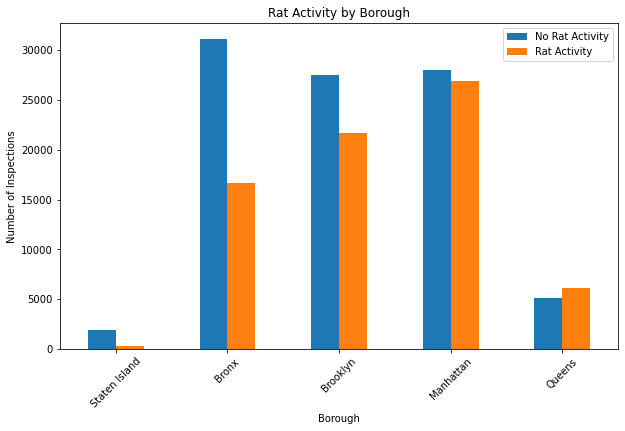

In [42]:
# Grouping by borough and RAT_ACTIVITY, then unstacking for plotting
borough_rat_activity = df.groupby(['BOROUGH', 'RAT_ACTIVITY']).size().unstack()

# Sorting the data if needed
borough_order = ['Staten Island', 'Bronx', 'Brooklyn', 'Manhattan', 'Queens']
borough_rat_activity = borough_rat_activity.reindex(borough_order).fillna(0)

# Plotting the data
borough_rat_activity.plot(kind='bar', figsize=(10, 6))

# Customize the plot
plt.title('Rat Activity by Borough')
plt.xlabel('Borough')
plt.ylabel('Number of Inspections')
plt.xticks(rotation=45)
plt.legend(["No Rat Activity", "Rat Activity"], loc='upper right')  # Adjusting the legend

# Save the plot
plt.savefig("./Graphics/rat-activity-by-borough.png")

# Show the plot
plt.show()